https://www.sciencedirect.com/science/article/pii/S0378437108009485

In [1]:
%load_ext autoreload
%autoreload 2

# Grafos temporales (Temporal graphs)

## Proximidad temporal (Temporal proximity)

### Setup

Importar las librerías de trabajo:

In [2]:
import networkx as nx
import datetime
import pandas as pd
from temporal_graph import TemporalGraph

Generamos la data (data ejemplo del paper).

La diferencia de tiempo, la expresamos en días:

In [3]:
tiempos = [(2018, 12, 31),
           (2019, 1, 1),
           (2019, 1, 3),
           (2019, 1, 5),
           (2019, 1, 9),
           (2019, 1, 14),
           (2019, 1, 20)]

In [4]:
data = pd.DataFrame({
    'sender': ['A', 'A', 'E', 'B', 'B', 'D', 'A'],
    'recipient': ['B', 'C, E', 'D', 'C', 'D', 'B', 'D'],
    'time': [ datetime.datetime(A, mes, dia) for (A, mes, dia) in tiempos]
})
data

,sender,recipient,time
0,A,B,2018-12-31
1,A,"C, E",2019-01-01
2,E,D,2019-01-03
3,B,C,2019-01-05
4,B,D,2019-01-09
5,D,B,2019-01-14
6,A,D,2019-01-20


Con esta data, creamos el grafo temporal: 

<div class="alert alert-info">
<h4>Creación del grafo temporal</h4>
<p>Necesitamos enviarle al constructor ``todos`` los tiempos que entran en juego en la vida del grafo.</p>
<p>Con esto, el grafo temporal crea las columnas donde se ubicarán las instancia de los nodos.</p>
</div>

In [5]:
grafo_temporal = TemporalGraph(data.time)

Con el grafo temporal construido, creamos las instancias y los enlaces desde la data de ejemplo:

In [6]:
grafo_temporal.build_links_from_data(data=data)

Enlace:  A B 2018-12-31 00:00:00 A1
Enlace:  A C 2019-01-01 00:00:00 A2
Enlace:  A E 2019-01-01 00:00:00 A2
Enlace:  E D 2019-01-03 00:00:00 E3
Enlace:  B C 2019-01-05 00:00:00 B4
Enlace:  B D 2019-01-09 00:00:00 B5
Enlace:  D B 2019-01-14 00:00:00 D6
Enlace:  A D 2019-01-20 00:00:00 A7


Y dibujamos para verificar la correcta creación de los enlaces:

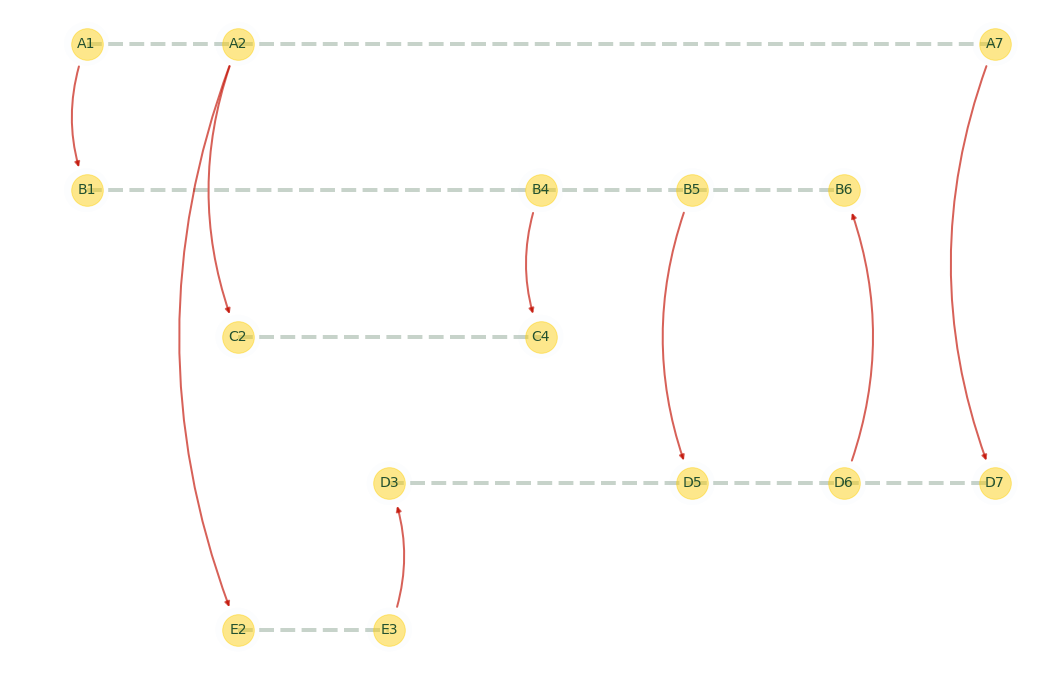

In [7]:
grafo_temporal.plot()

### Caminos (paths):

Camino mas corto desde A1 a C4: 

In [8]:
nx.algorithms.shortest_path(grafo_temporal.get_graph(), 'A1', 'C4')

['A1', 'B1', 'B4', 'C4']

Pero hay dos caminos de igual distancia temporal. Mostrar todos:

In [9]:
for p in nx.algorithms.all_shortest_paths(grafo_temporal.get_graph(), 'A1', 'C4'):
    print(p)

['A1', 'B1', 'B4', 'C4']
['A1', 'A2', 'C2', 'C4']


Camino mas corto de B4 a B6:

In [10]:
for p in nx.algorithms.all_shortest_paths(grafo_temporal.get_graph(), 'B4', 'B6'):
    print(p)

['B4', 'B5', 'B6']


Todos los caminos de B4 a B6:

In [11]:
for p in nx.algorithms.all_simple_paths(grafo_temporal.get_graph(), 'B4', 'B6'):
    print(p)

['B4', 'B5', 'D5', 'D6', 'B6']
['B4', 'B5', 'B6']


### Instancias de los nodos:

In [12]:
grafo_temporal.get_graph().has_node('A2')

True

In [13]:
grafo_temporal._get_first_instance_from_time('D', 5)

'D5'

In [14]:
grafo_temporal._get_last_instance_after_time('D', 4)

'D3'

In [15]:
try:
    grafo_temporal._get_first_instance_from_time('D', 9)
except Exception as e:
    print('Excepcion:\n', e)

Excepcion:
 No se puede encontrar una instancia del nodo "D" posterior al tiempo 9 recibido


In [16]:
grafo_temporal._get_first_instance_from_time('D')

'D3'

In [17]:
grafo_temporal._get_last_instance_after_time('D', 4)

'D3'

In [18]:
grafo_temporal._get_last_instance_after_time('D', 6)

'D6'

In [19]:
grafo_temporal._get_last_instance_after_time('A', 5)

'A2'

# Proximidad temporal:

En nuestro caso, como nos manejamos con distancias de días, la distancia entre fechas python, nos retorna una cantidad en segundos.

Por lo cuál, generamos una funcion que nos pase una cantidad de tiempo en segundos a una cantidad de tiempo en días:

In [20]:
def seconds_to_days(seconds):
    if seconds is None:
        return None
    return (seconds / 3600) / 24

La distancia temporal entre un nodo X y un nodo Y está definida por:
    
    p(X,Y,ta,tb) 
    
donde ta es una precondición temporal y tb es una postcondicion temporal.

Ambas condiciones temporales (ta y tb) pueden tener un valor o ser null. Lo que nos deja 4 posibles casos.

### p(A,D,ti,tj): 

The shortest path between some instance of A, e.g. At2, and some instance of D, e.g. Dt7.

This example is equivalent to p(A,D,t2,t7) and intuitively means:

    - “Given t2, find the shortest path from A to D such that D is reached at t7”.

In this case, the shortest path has weight w(At2,At7,Dt7) = 19, which translates back to AD.

In [21]:
shortest_path = grafo_temporal.temporal_proximity('A', 'D', 2, 7)
shortest_path

['A2', 'A7', 'D7']

Peso del camino (segundos):

In [22]:
grafo_temporal.weight(shortest_path)

1641600.0

Peso del camino (días):

In [23]:
seconds_to_days(grafo_temporal.weight(shortest_path))

19.0

In [24]:
grafo_temporal.temporal_proximity('A', 'A', 2, 7)

['A2', 'A7']

In [25]:
grafo_temporal.temporal_proximity('A', 'D', 2, 5)

['A2', 'E2', 'E3', 'D3', 'D5']

### p(A,D,ti,null):

The shortest path between some instance of A, e.g. At1, and any instance of D ({Dt3, Dt5, Dt6, Dt7}).

This example is equivalent to p(A,D,t1, null), and intuitively means:
    
    - “Given time t1, find the shortest path from A to D”.

In this case, the shortest path is AED with total weight w(At1,At2,Et2,Et3,Dt3) = 1+0+2+0=3. 

In [26]:
grafo_temporal.temporal_proximity('A', 'D', time_from=1, time_to=None)

['A1', 'A2', 'E2', 'E3', 'D3']

Peso del camino:

In [27]:
seconds_to_days(grafo_temporal.weight(grafo_temporal.temporal_proximity('A',
                                                                        'D',
                                                                        time_from=1,
                                                                        time_to=None)))

3.0

In [28]:
grafo_temporal.temporal_proximity('A', 'D', time_from=2)

['A2', 'E2', 'E3', 'D3']

In [29]:
grafo_temporal.temporal_proximity('A', 'D', time_from=4)

['A7', 'D7']

In [30]:
grafo_temporal.temporal_proximity('B', 'E', time_from=2)

[]

##### Tests:

En los algoritmos internos, es conveniente saber si existe un camino desde un nodo a otro o saber todas las instancias de un nodo:

In [31]:
nx.algorithms.has_path(grafo_temporal.get_graph(), 'A1', 'D5')

True

In [32]:
grafo_temporal._get_node_instances('A')

['A1', 'A2', 'A7']

In [33]:
grafo_temporal._get_node_instances('A', from_time=2)

['A2', 'A7']

In [34]:
grafo_temporal._get_node_instances('A', from_time=4)

['A7']

In [35]:
grafo_temporal._get_node_instances('A', to_time=2)

['A1', 'A2']

In [36]:
grafo_temporal._get_node_instances('A', to_time=9)

['A1', 'A2', 'A7']

In [37]:
grafo_temporal._get_node_instances('A', to_time=1)

['A1']

### p(A,D,null,ti):

The shortest path between any instance of A ({At1, At2, At3, At7}) and some instance of D, e.g. Dt5. 
    
This example is equivalent to p(A,D,null,t5) and intuitively means:

    - "Find the shortest path from A to D such that D is reached at t5".

In this case, there are two shortest paths with weight w(At1 At2 Et2 Et3 Dt3 Dt5) = w(At1 Bt1 Bt4 Bt5 Dt5) = 9, which translate back to AED and ABD respectively.

In [38]:
shortest_path = grafo_temporal.temporal_proximity('A', 'D', time_to=5)
shortest_path

['A1', 'B1', 'B4', 'B5', 'D5']

Peso del camino:

In [39]:
seconds_to_days(grafo_temporal.weight(shortest_path))

9.0

In [40]:
grafo_temporal.temporal_proximity('A', 'C', time_to=4)

['A1', 'B1', 'B4', 'C4']

In [41]:
grafo_temporal.temporal_proximity('A', 'C', time_to=5)

['A1', 'B1', 'B4', 'C4']

In [42]:
try:
    grafo_temporal.temporal_proximity('A', 'D', time_to=2)
except Exception as e:
    print(e)

El nodo destino D no tiene instancias instancias anteriores al tiempo 2


### p(A,D,null,null): 

The shortest path between any instance of A ({At1, At2, At3, At7}) and any instance of D ({Dt3, Dt5, Dt6, Dt7}). This intuitively means:
    - "find the shortest possible path from A to D throughout the entire dataset".

In this case, the shortest path is w(At7,Dt7) = 0, which translates back to AD.

In [43]:
shortest_path = grafo_temporal.temporal_proximity('A', 'D')
shortest_path

['A7', 'D7']

In [44]:
seconds_to_days(grafo_temporal.weight(shortest_path))

0.0

In [45]:
grafo_temporal.temporal_proximity('B', 'D')

['B5', 'D5']

In [46]:
grafo_temporal.temporal_proximity('B', 'C')

['B4', 'C4']

In [47]:
grafo_temporal.temporal_proximity('E', 'A')

[]

In [48]:
grafo_temporal.temporal_proximity('E', 'B')

['E3', 'D3', 'D5', 'D6', 'B6']

In [49]:
grafo_temporal.temporal_proximity('E', 'D', time_from=2, time_to=6)

['E2', 'E3', 'D3', 'D5', 'D6']

### Peso del camino (Path weight): 

In [50]:
grafo_temporal.get_graph().get_edge_data('D5', 'D6')

{'weight': 432000.0}

In [51]:
grafo_temporal.weight(['D5', 'D6'])

432000.0

In [52]:
grafo_temporal.temporal_proximity('A', 'D', time_to=5)

['A1', 'B1', 'B4', 'B5', 'D5']

In [53]:
grafo_temporal.weight(['A1', 'A2', 'E2', 'E3', 'D3', 'D5'])

777600.0

In [54]:
grafo_temporal.weight(grafo_temporal.temporal_proximity('A', 'D', time_to=5))

777600.0

In [55]:
grafo_temporal.temporal_proximity('A', 'C', time_to=2)

['A1', 'A2', 'C2']

In [56]:
grafo_temporal.weight(['A1', 'A2', 'C2'])

86400.0

In [57]:
grafo_temporal.weight(['A1', 'A2'])

86400.0

## Proximidad temporal promedio:

In [58]:
avg_tmp_proximity = grafo_temporal.average_temporal_proximity('A', 'D')
print(avg_tmp_proximity, '-->', seconds_to_days(avg_tmp_proximity))

144000.0 --> 1.6666666666666667


In [59]:
print(grafo_temporal.weight(['A1', 'A2']), '-->', seconds_to_days(grafo_temporal.weight(['A1', 'A2'])))

86400.0 --> 1.0


In [60]:
grafo_temporal.average_temporal_proximity('A', 'D', verbose=True)

Average temporal proximity from A to D

-- Iteration start --
Temporal proximity from A to D

	Searching from: A1
	From: A1
	Destination: D3?
		Have path, save: 
		['A1', 'A2', 'E2', 'E3', 'D3']
		next node instance destination...
In t:1
	distance from A to D
	path: ['A1', 'A2', 'E2', 'E3', 'D3']


Temporal proximity from A to D

	Searching from: A2
	From: A2
	Destination: D3?
		Have path, save: 
		['A2', 'E2', 'E3', 'D3']
		next node instance destination...
In t:2
	distance from A to D
	path: ['A2', 'E2', 'E3', 'D3']


Temporal proximity from A to D

	Searching from: A7
	From: A7
	Destination: D7?
		Have path, save: 
		['A7', 'D7']
		next node instance destination...
In t:7
	distance from A to D
	path: ['A7', 'D7']


-- Iteration finished --


144000.0

In [61]:
seconds_to_days(144000)

1.6666666666666667

In [62]:
# A a D desde t1
seconds = grafo_temporal.weight(['A1', 'A2', 'E2', 'E3', 'D3'])
(seconds/3600)/24

3.0

In [63]:
# A a D desde t2
seconds = grafo_temporal.weight(['A2', 'E2', 'E3', 'D3'])
((seconds)/3600)/24

2.0

In [64]:
(grafo_temporal.average_temporal_proximity('A', 'B', verbose=True) / 3600) / 24

Average temporal proximity from A to B

-- Iteration start --
Temporal proximity from A to B

	Searching from: A1
	From: A1
	Destination: B1?
		Have path, save: 
		['A1', 'B1']
		next node instance destination...
In t:1
	distance from A to B
	path: ['A1', 'B1']


Temporal proximity from A to B

	Searching from: A2
	From: A2
	Destination: B4?
	Destination: B5?
	Destination: B6?
		Have path, save: 
		['A2', 'E2', 'E3', 'D3', 'D5', 'D6', 'B6']
		next node instance destination...
In t:2
	distance from A to B
	path: ['A2', 'E2', 'E3', 'D3', 'D5', 'D6', 'B6']


Temporal proximity from A to B

	Searching from: A7
	From: A7
In t:7
	distance from A to B
	path: []


-- Iteration finished --


6.5

In [65]:
(grafo_temporal.average_temporal_proximity('A', 'C') / 3600) / 24

0.5

In [66]:
(grafo_temporal.average_temporal_proximity('A', 'D') / 3600) / 24

1.6666666666666667

In [67]:
(grafo_temporal.average_temporal_proximity('A', 'E') / 3600) / 24

0.5

In [68]:
(grafo_temporal.average_temporal_proximity('B', 'C') / 3600) / 24

2.5

In [69]:
(grafo_temporal.average_temporal_proximity('B', 'D') / 3600) / 24

4.333333333333333

Distancia temporal promedio nula:

In [70]:
grafo_temporal.average_temporal_proximity('B', 'A', verbose=True)

Average temporal proximity from B to A

-- Iteration start --
Temporal proximity from B to A

	Searching from: B1
	From: B1
	Destination: A1?
	Destination: A2?
	Destination: A7?
In t:1
	distance from B to A
	path: []


Temporal proximity from B to A

	Searching from: B4
	From: B4
	Destination: A7?
In t:4
	distance from B to A
	path: []


Temporal proximity from B to A

	Searching from: B5
	From: B5
	Destination: A7?
In t:5
	distance from B to A
	path: []


Temporal proximity from B to A

	Searching from: B6
	From: B6
	Destination: A7?
In t:6
	distance from B to A
	path: []


-- Iteration finished --


Distancia temporal promedio 0:

In [71]:
seconds_to_days((grafo_temporal.average_temporal_proximity('B', 'B', verbose=True)))

Average temporal proximity from B to B

-- Iteration start --
Temporal proximity from B to B

	Searching from: B1
	From: B1
	Destination: B1?
		Have path, save: 
		['B1']
		next node instance destination...
In t:1
	distance from B to B
	path: ['B1']


Temporal proximity from B to B

	Searching from: B4
	From: B4
	Destination: B4?
		Have path, save: 
		['B4']
		next node instance destination...
In t:4
	distance from B to B
	path: ['B4']


Temporal proximity from B to B

	Searching from: B5
	From: B5
	Destination: B5?
		Have path, save: 
		['B5']
		next node instance destination...
In t:5
	distance from B to B
	path: ['B5']


Temporal proximity from B to B

	Searching from: B6
	From: B6
	Destination: B6?
		Have path, save: 
		['B6']
		next node instance destination...
In t:6
	distance from B to B
	path: ['B6']


-- Iteration finished --


0.0

In [72]:
(grafo_temporal.average_temporal_proximity('D', 'B', verbose=True) / 3600) / 24

Average temporal proximity from D to B

-- Iteration start --
Temporal proximity from D to B

	Searching from: D3
	From: D3
	Destination: B4?
	Destination: B5?
	Destination: B6?
		Have path, save: 
		['D3', 'D5', 'D6', 'B6']
		next node instance destination...
In t:3
	distance from D to B
	path: ['D3', 'D5', 'D6', 'B6']


Temporal proximity from D to B

	Searching from: D5
	From: D5
	Destination: B5?
	Destination: B6?
		Have path, save: 
		['D5', 'D6', 'B6']
		next node instance destination...
In t:5
	distance from D to B
	path: ['D5', 'D6', 'B6']


Temporal proximity from D to B

	Searching from: D6
	From: D6
	Destination: B6?
		Have path, save: 
		['D6', 'B6']
		next node instance destination...
In t:6
	distance from D to B
	path: ['D6', 'B6']


Temporal proximity from D to B

	Searching from: D7
	From: D7
In t:7
	distance from D to B
	path: []


-- Iteration finished --


5.333333333333333

In [73]:
(grafo_temporal.average_temporal_proximity('E', 'B', verbose=True) / 3600) / 24

Average temporal proximity from E to B

-- Iteration start --
Temporal proximity from E to B

	Searching from: E2
	From: E2
	Destination: B4?
	Destination: B5?
	Destination: B6?
		Have path, save: 
		['E2', 'E3', 'D3', 'D5', 'D6', 'B6']
		next node instance destination...
In t:2
	distance from E to B
	path: ['E2', 'E3', 'D3', 'D5', 'D6', 'B6']


Temporal proximity from E to B

	Searching from: E3
	From: E3
	Destination: B4?
	Destination: B5?
	Destination: B6?
		Have path, save: 
		['E3', 'D3', 'D5', 'D6', 'B6']
		next node instance destination...
In t:3
	distance from E to B
	path: ['E3', 'D3', 'D5', 'D6', 'B6']


-- Iteration finished --


12.0

### Por último, construir la tabla de proximidades temporales.

In [74]:
seconds_to_days(
    grafo_temporal.average_temporal_proximity('B', 'D'))

4.333333333333333

In [75]:
seconds_to_days(
    grafo_temporal.average_temporal_proximity('D', 'B'))

5.333333333333333

Nodos:

In [76]:
nodos = list(pd.Series(data.sender.unique()).append(pd.Series(data.recipient[ data.recipient.str.len() == 1].unique())))
nodos = sorted(list(set(nodos)))
nodos

['A', 'B', 'C', 'D', 'E']

In [77]:
table = {}
for nodo in nodos:
    # Para cada nodo:
    # Primero calcular las proximidades temporales promedios contra los demas nodos:
    table[nodo] = [
        seconds_to_days(grafo_temporal.average_temporal_proximity( y, nodo ))
        for y in nodos ]
    
    # Luego agregar a la lista el promedio de alcance hacia el nodo
    # por parte de los demas nodos:
    
    # entonces, filtrar para eliminar los valores None:
    vertical_avgs = list(filter(lambda e: e is not None, table[nodo]))
    try:
        # agregar el P_in para el nodo
        table[nodo].append(
            sum( vertical_avgs ) / (len( vertical_avgs ) -1))  # -1 para no contemplar la distancia hacia el propio nodo
    except ZeroDivisionError:
        table[nodo].append(None)
table

{'A': [0.0, None, None, None, None, None],
 'B': [6.5, 0.0, None, 5.333333333333333, 12.0, 7.944444444444444],
 'C': [0.5, 2.5, 0.0, None, None, 1.5],
 'D': [1.6666666666666667,
  4.333333333333333,
  None,
  0.0,
  1.0,
  2.3333333333333335],
 'E': [0.5, None, None, None, 0.0, 0.5]}

Nos hace falta una nueva columna con los valores de cuán rápido alcanza la red cada nodo (P out): 

In [78]:
P_out = []
for nodo in nodos:
    # Invertir el lugar del nodo para obtener la vista horizontal:
    horizontal_avgs = [
        seconds_to_days(
            grafo_temporal.average_temporal_proximity( nodo, y ))
        for y in nodos ]
    horizontal_avgs = list(
        filter(
            lambda i_avg: i_avg is not None,
            horizontal_avgs))
    try:
        P_out.append(sum(horizontal_avgs) / (len(horizontal_avgs) -1))
    except ZeroDivisionError:
        P_out.append(None)
P_out.append('-')
P_out

[2.2916666666666665, 3.4166666666666665, None, 5.333333333333333, 6.5, '-']

In [79]:
table['Pout'] = P_out
table

{'A': [0.0, None, None, None, None, None],
 'B': [6.5, 0.0, None, 5.333333333333333, 12.0, 7.944444444444444],
 'C': [0.5, 2.5, 0.0, None, None, 1.5],
 'D': [1.6666666666666667,
  4.333333333333333,
  None,
  0.0,
  1.0,
  2.3333333333333335],
 'E': [0.5, None, None, None, 0.0, 0.5],
 'Pout': [2.2916666666666665,
  3.4166666666666665,
  None,
  5.333333333333333,
  6.5,
  '-']}

In [80]:
index = nodos.copy()
index.append('Pin')
index

['A', 'B', 'C', 'D', 'E', 'Pin']

In [81]:
nodos

['A', 'B', 'C', 'D', 'E']

In [82]:
for nodo in table:
    table[nodo] = [value if value is not None else '-' for value in table[nodo]]
table

{'A': [0.0, '-', '-', '-', '-', '-'],
 'B': [6.5, 0.0, '-', 5.333333333333333, 12.0, 7.944444444444444],
 'C': [0.5, 2.5, 0.0, '-', '-', 1.5],
 'D': [1.6666666666666667,
  4.333333333333333,
  '-',
  0.0,
  1.0,
  2.3333333333333335],
 'E': [0.5, '-', '-', '-', 0.0, 0.5],
 'Pout': [2.2916666666666665,
  3.4166666666666665,
  '-',
  5.333333333333333,
  6.5,
  '-']}

##### tabla:

In [83]:
average_temporal_proximities = pd.DataFrame(table, index=index)
average_temporal_proximities

,A,B,C,D,E,Pout
A,0,6.5,0.5,1.66667,0.5,2.29167
B,-,0,2.5,4.33333,-,3.41667
C,-,-,0,-,-,-
D,-,5.33333,-,0,-,5.33333
E,-,12,-,1,0,6.5
Pin,-,7.94444,1.5,2.33333,0.5,-


> TODO: Generar los metodos que nos permitan solicitar estos valores al grafo temporal:

### Proximidades temporales promedios contra los demás nodos:

#### Desde un nodo:

In [125]:
avg_tmp_proxs_from_a = grafo_temporal.average_temporal_proximity_from_node('A')
avg_tmp_proxs_from_a

{'A': 0.0, 'B': 561600.0, 'C': 43200.0, 'D': 144000.0, 'E': 43200.0}

pasar a dias:

In [127]:
[seconds_to_days(avg_tmp_proxs_from_a.get(e)) for e in avg_tmp_proxs_from_a]

[0.0, 6.5, 0.5, 1.6666666666666667, 0.5]

Alcance del nodo hacia el resto de nodos del grafo (promedio de los valores no nulos del vector de arriba):

In [132]:
grafo_temporal.average_temporal_reach('A')

198000.0

...expresado en días:

In [134]:
seconds_to_days(grafo_temporal.average_temporal_reach('A'))

2.2916666666666665

mismo test para el nodo E:

In [136]:
print(
    grafo_temporal.average_temporal_proximity_from_node('E'),
    '--> P out:',
    seconds_to_days(grafo_temporal.average_temporal_reach('E')))

{'A': None, 'B': 1036800.0, 'C': None, 'D': 86400.0, 'E': 0.0} --> P out: 6.5


#### Hasta un nodo:

In [137]:
grafo_temporal.average_temporal_proximity_to_node('A')

{'A': 0.0, 'B': None, 'C': None, 'D': None, 'E': None}

In [141]:
grafo_temporal.average_temporal_proximity_to_node('D')

{'A': 144000.0, 'B': 374400.0, 'C': None, 'D': 0.0, 'E': 86400.0}

Columna para el nodo 'D:' 

In [140]:
aux = grafo_temporal.average_temporal_proximity_to_node('D')
print(
    [seconds_to_days(proximity) for proximity in aux.values()])

[1.6666666666666667, 4.333333333333333, None, 0.0, 1.0]


In [145]:
grafo_temporal.average_temporal_reachability('D')

201600.0

In [149]:
aux = grafo_temporal.average_temporal_proximity_to_node('D')
print(
    [seconds_to_days(proximity) for proximity in aux.values()],
    '--> P in:',
    seconds_to_days(grafo_temporal.average_temporal_reachability('D'))
)


[1.6666666666666667, 4.333333333333333, None, 0.0, 1.0] --> P in: 2.3333333333333335
